In [183]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

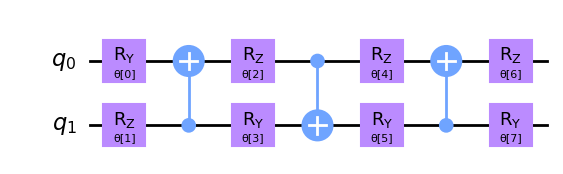

In [184]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.ry(params[0], 0) #new gate
    target.rz(params[1], 1) #was -np.pi / 2
    target.cx(1, 0)
    target.rz(params[2], 0) #was 0
    target.ry(params[3], 1) #was 1
    target.cx(0, 1)
    target.rz(params[4], 0) #new gate 
    target.ry(params[5], 1) #was 2
    target.cx(1, 0)
    target.rz(params[6], 0) #was np.pi / 2
    target.ry(params[7], 1) #new circuit
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=8) #was 3
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

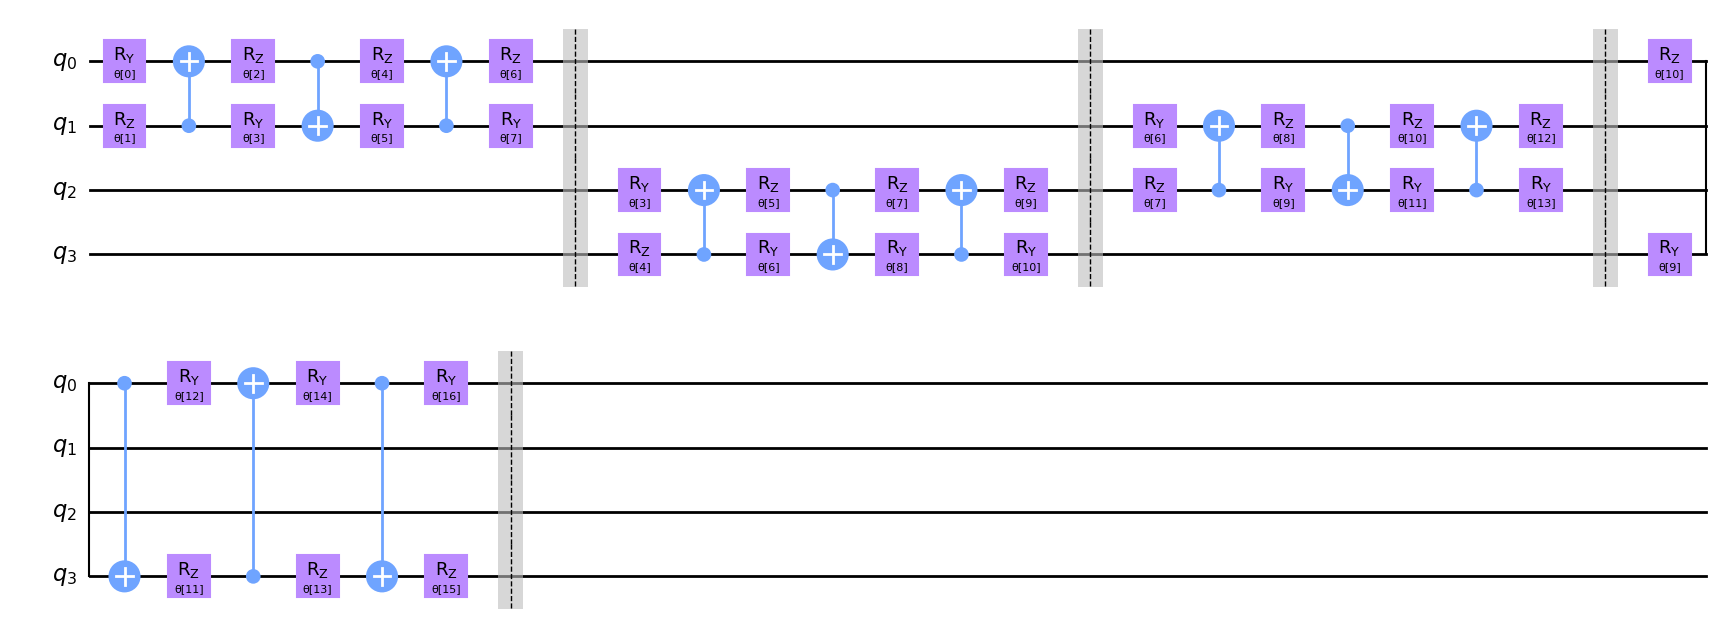

In [185]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=8*num_qubits) #was 3
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 8)]), [q1, q2]) #was 3
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 8)]), [q1, q2]) #was 3
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

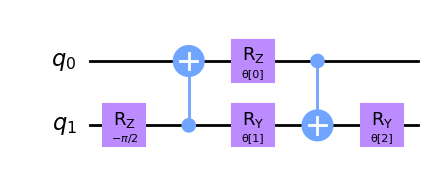

In [186]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")fit

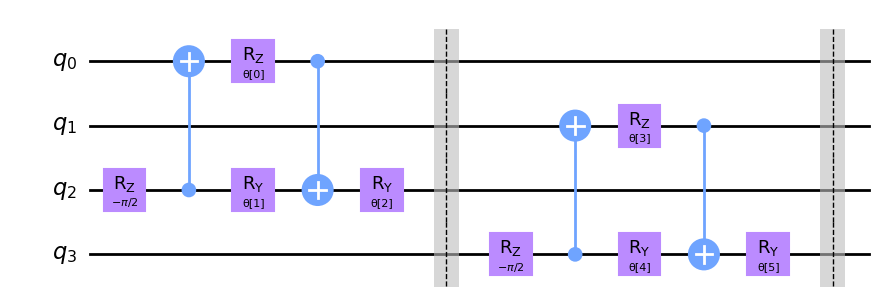

In [187]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

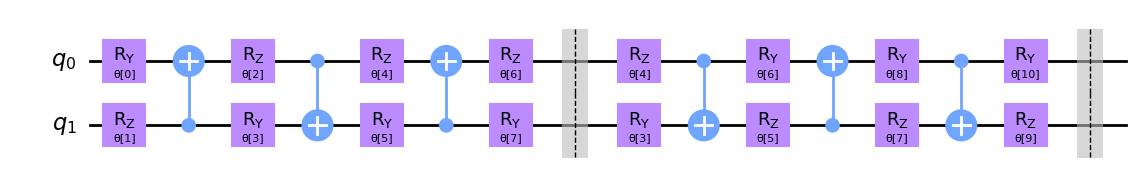

In [249]:
def fc_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Fully Connected Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=8*num_qubits) #was 3
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 8)]), [q1, q2]) #was 3
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 8)]), [q1, q2]) #was 3
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = fc_layer(2, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [188]:
def complex_str_to_float(complex_str):
    complex_num = complex(complex_str)
    return complex_num.real


SIZE = 5

df = pd.read_csv('train_test_df.csv')

sampled_df = df.groupby('phase').apply(lambda x: x.sample(SIZE)).reset_index(drop=True)

X_df = sampled_df.iloc[:, 10:-1]
X_df = X_df.map(complex_str_to_float)

y_df = sampled_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, stratify=y_df)

/tmp/ipykernel_117540/524274411.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('phase').apply(lambda x: x.sample(SIZE)).reset_index(drop=True)


In [189]:
y_train.value_counts()

phase
2    4
1    4
3    4
4    4
Name: count, dtype: int64

In [190]:
X_train_list = [x for x in X_train.values]
y_train_list = y_train.values
X_test_list = [x for x in X_test.values]
y_test_list = y_test.values

In [191]:
X_train_list[1].shape

(256,)

In [263]:
# from qiskit.aqua.components.feature_maps import RawFeatureVector

from qiskit_machine_learning.circuit.library.raw_feature_vector import RawFeatureVector
feature_map = RawFeatureVector(256) # ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Fully Connected Layer
ansatz.compose(fc_layer(2, "f"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

# we decompose the circuit for the QNN to avoid additional data copying
qnn = SamplerQNN(
    circuit=circuit,#.decompose(),
    interpret=lambda measured_int: measured_int >> 6,
    output_shape=4,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [264]:
len(ansatz.parameters)

75

In [265]:
qnn.output_shape

(4,)

In [266]:
qnn.forward([X_train_list[0]], weights=np.random.rand(75))

array([[0.24339078, 0.17059056, 0.28681956, 0.2991991 ]])

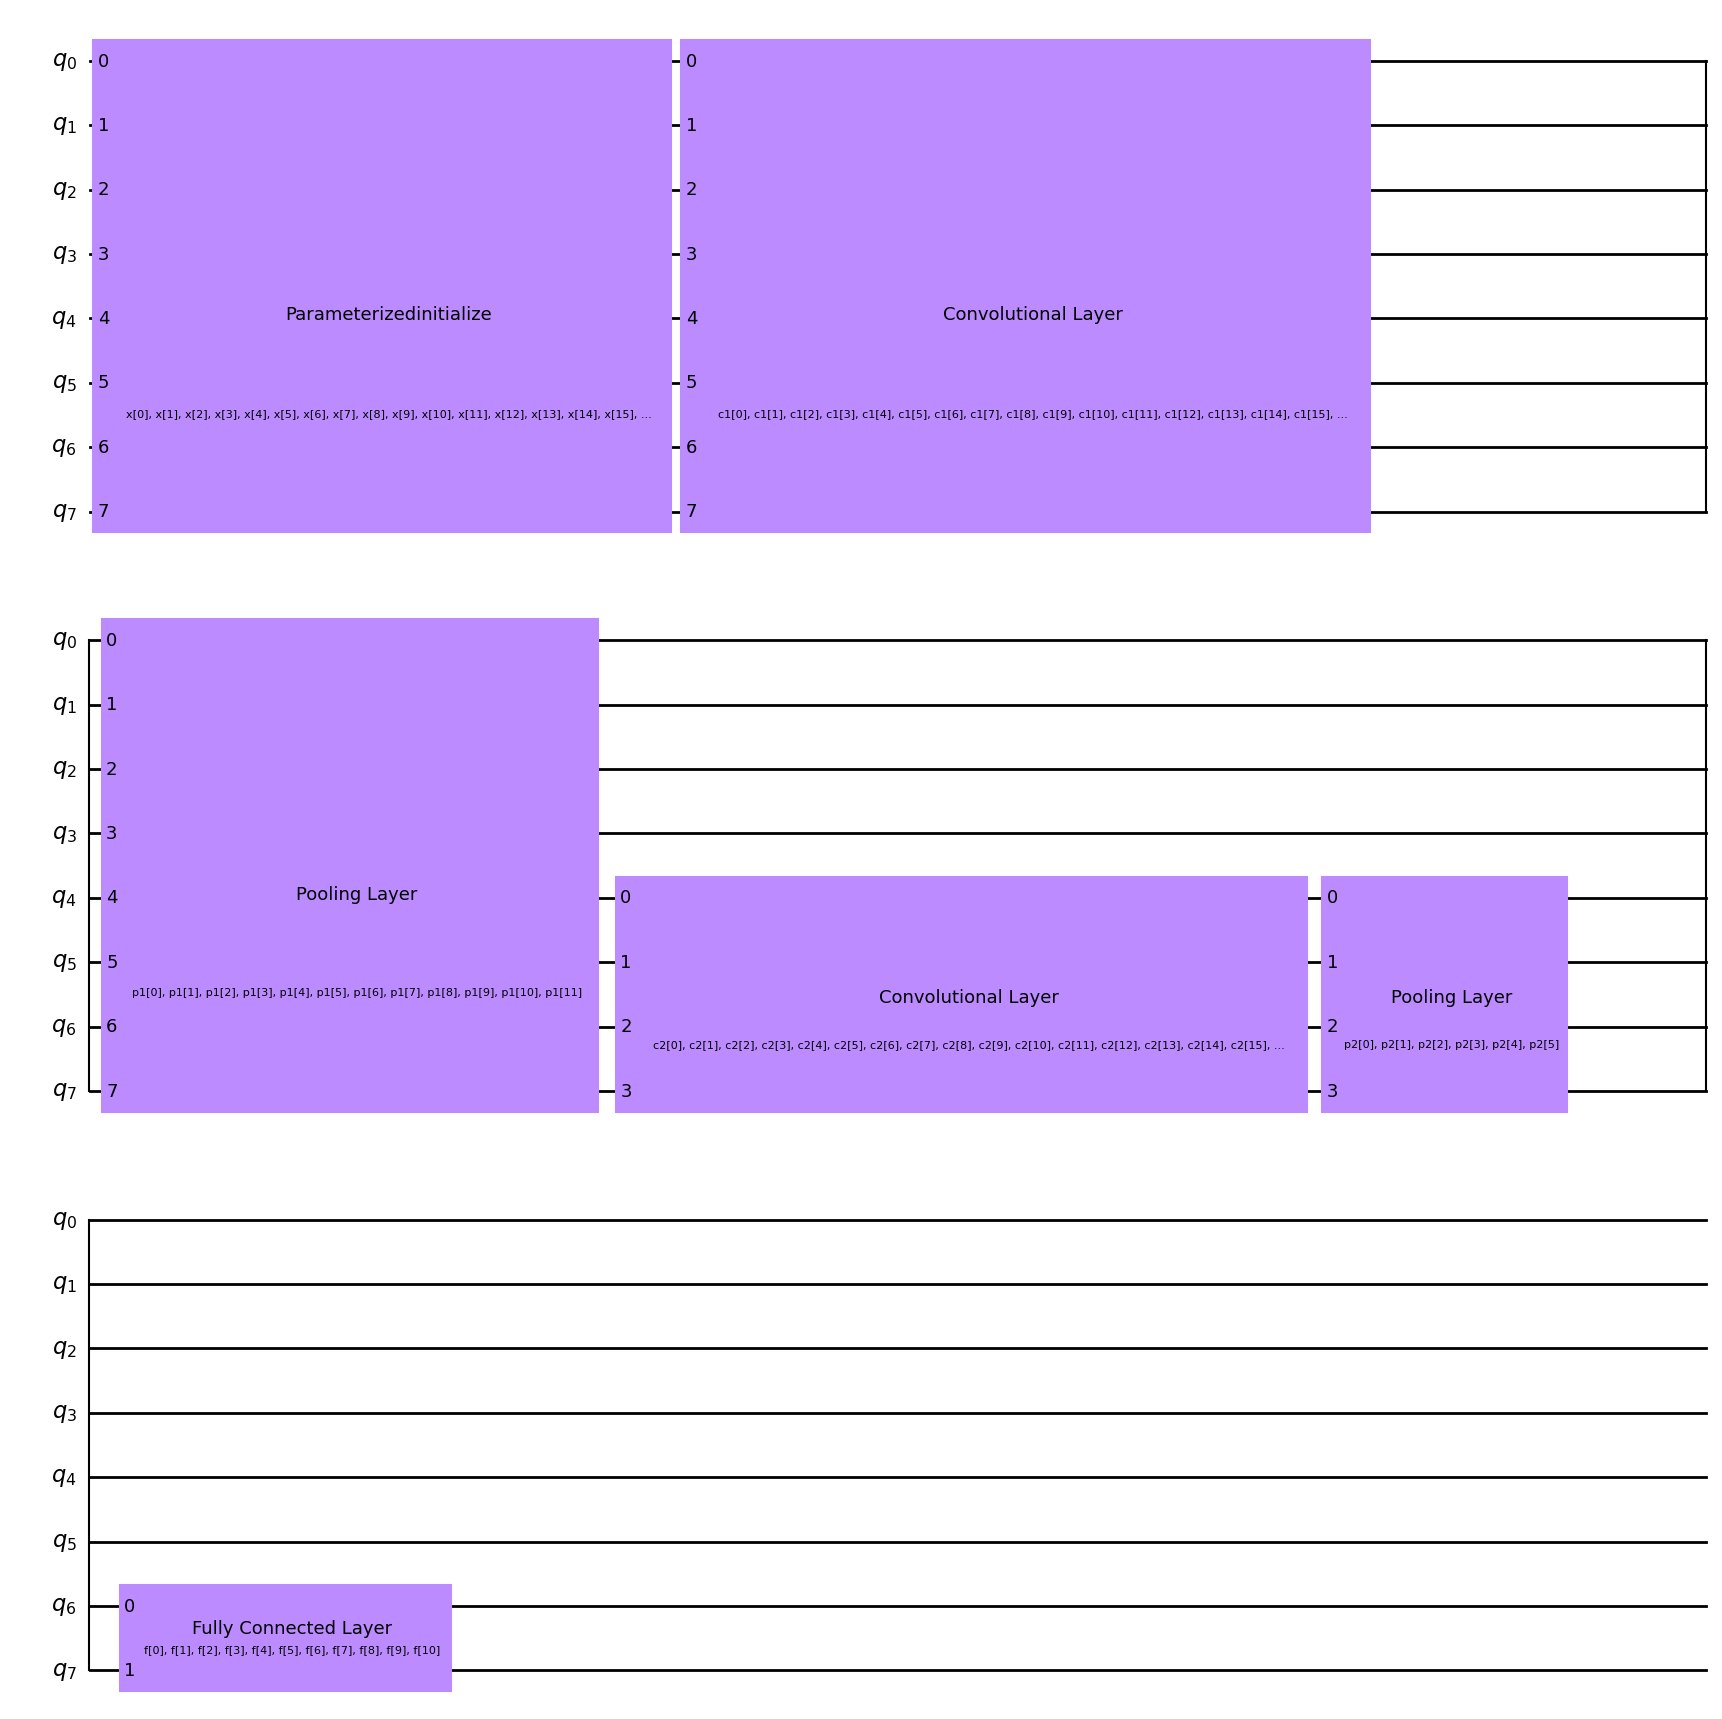

In [267]:
circuit.draw("mpl", style="clifford")

In [235]:
len(circuit.parameters) - 256

75

In [196]:
def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)

In [197]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=1000),  # Set max iterations here
    callback=callback_graph,
    loss='cross_entropy',
    one_hot=True
)

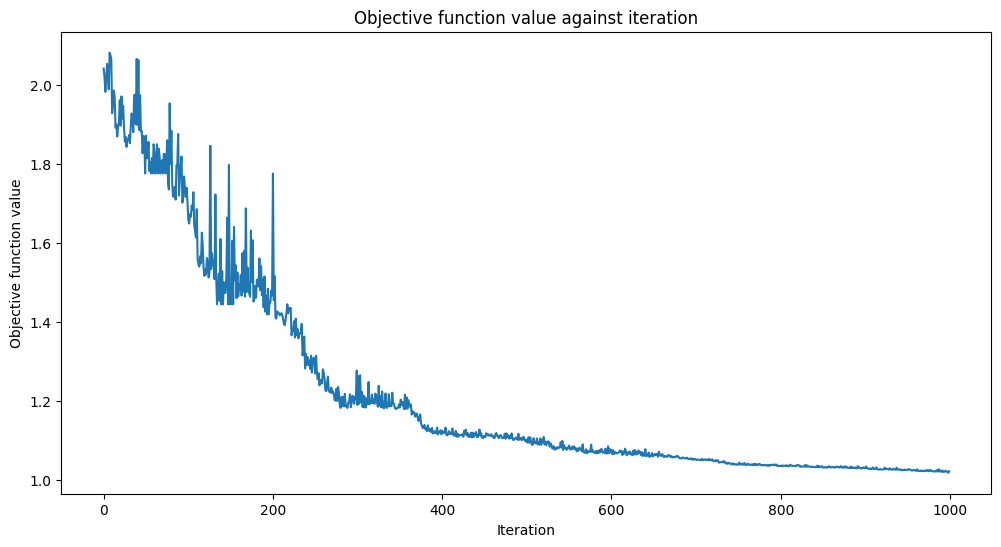

In [198]:
x = np.asarray(X_train_list)
y = np.asarray(y_train_list)

objective_func_vals = []
classifier.fit(x, y)

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(objective_func_vals)), objective_func_vals)
plt.show()

In [199]:
# score classifier
# print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [200]:
y_test

9     2
3     1
19    4
12    3
Name: phase, dtype: int64

In [201]:
classifier.predict(X_test)

array([2, 3, 4, 3])

In [219]:
LOAD_SAMPLE = False
if LOAD_SAMPLE:
    df_sample_big = pd.read_pickle("df_sample_big.pkl")
else:
    df_sample_big = df.groupby('phase').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)
X_test_big = df_sample_big.iloc[:, 10:-1].map(complex_str_to_float)
y_test_big = df_sample_big.iloc[:,-1]
info_test_big = df_sample_big[["Unnamed: 0", "J2", "J2", "mag_x", "mesh_y", "mesh_z", "gap", "entropy", "cv", "chi"]]
X_test_big = [x for x in X_test_big.values]
y_test_big = y_test_big.values

/tmp/ipykernel_117540/3284304758.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample_big = df.groupby('phase').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)


In [220]:
y_pred_big = classifier.predict(X_test_big)
print(f"Accuracy: {np.mean(y_pred_big == y_test_big)}")

Accuracy: 0.915


In [224]:
df_test_results = info_test_big.assign(predicted_phase = y_pred_big)
df_result = df.merge(df_test_results[["Unnamed: 0", "predicted_phase"]],
                     on="Unnamed: 0",
                     how='left')

In [225]:
def get_tested_points(df):
    df_tested = df[~df["predicted_phase"].isnull()].astype({"predicted_phase": np.int64})
    return df_tested

In [259]:
df_tested = get_tested_points(df_result)
df_tested.shape

(200, 268)

In [230]:
SAVE_DATASET = True
if SAVE_DATASET:
    df_result.iloc[:, 1:].to_csv("qae_train_test_solved_df.csv")

In [204]:
SAVE_SAMPLE = False
if SAVE_SAMPLE:
    df_sample_big.to_pickle("df_sample_big.pkl")

In [205]:
import pickle as pkl
SAVE_MODEL = True
SAVE_RESULTS = True

if SAVE_MODEL:
    classifier.save("qae-classifier.obj")
if SAVE_RESULTS:
    with open("qae-results.pkl", 'wb') as f:
        pkl.dump(objective_func_vals, f)

In [206]:
# to load model object, set LOAD_MODEL to True
LOAD_MODEL = True
if LOAD_MODEL:
    loaded_classifier = NeuralNetworkClassifier(
        qnn,
        optimizer=COBYLA(maxiter=1000),  # Set max iterations here
        callback=callback_graph,
    )
    loaded_classifier.load("qae-classifier.obj")

In [207]:
# to load result object, set LOAD_RESULTS to True
LOAD_RESULTS = True
if LOAD_RESULTS:
    with open("qae-results.pkl", 'rb') as f:

        obj_func_vals = pkl.load(f)

In [255]:
def point_position_relative_to_lines(x, y, lines):
    """
    Determine if the point (x, y) is above, below, or on each line in a list of lines, including vertical lines.

    Args:
    x (float): x-coordinate of the point.
    y (float): y-coordinate of the point.
    lines (list of tuples): Each tuple contains either (m, b) for non-vertical lines or ('vertical', c) for vertical lines.

    Returns:
    list: Each element is 1 (above), 0 (on), or -1 (below) for each corresponding line. For vertical lines, 1 (right), -1 (left).
    """
    results = []
    if y>1e-12:
      raise ValueError("incorrect input")
    for line in lines:
        if line[0] == 'vertical':  # Check if the line is vertical
            c = line[1]
            if x > c:
                results.append(1)  # The point is to the right of the vertical line
            elif x < c:
                results.append(-1)  # The point is to the left of the vertical line
            else:
                results.append(0)  # The point is on the vertical line
        else:
            m, b = line
            line_y = m * x + b
            if y > line_y:
                results.append(1)  # The point is above the line
            elif y < line_y:
                results.append(-1)  # The point is below the line
            else:
                results.append(0)  # The point is on the line
    return results

# Example usage

lines = [(-9, -1.8), ('vertical', 0), (1.8, -1.8), (-1, 1)]  # List of (slope, intercept) for each line
x, y = 4, -2  # Coordinates of the point

positions = point_position_relative_to_lines(x, y, lines)
positions

[1, 1, -1, 1]

In [256]:
def phase_encode(positions):
    if positions[0] <= 0 and positions[1] <= 0:
        return 1
    elif (positions[0]>= 0 and positions[1] <= 0) or (positions[2] >= 0 and positions[1] >= 0):
        return 2
    elif positions[1] >= 0 and (positions[2] <= 0 and positions[3] <= 0):
        return 3
    elif positions[3] > 0:
        return 4
    else:
      raise ValueError("incorrect input")

In [257]:
mesh_phase=np.zeros((len(np.arange(0,2,0.05)),len(np.arange(-2,2,0.05))))
mesh_phase_list=[]
J1_list=[]
J2_list=[]
for k,J1 in enumerate(np.arange(-4,4,0.1)):
  for i,J2 in enumerate(np.arange(0,-4,-0.1)):
    positions = point_position_relative_to_lines(J1,J2, lines)
    mesh_phase[i,k]=phase_encode(positions)
    mesh_phase_list.append(phase_encode(positions))
    J1_list.append(int(J1*10))
    J2_list.append(int(J2*10))

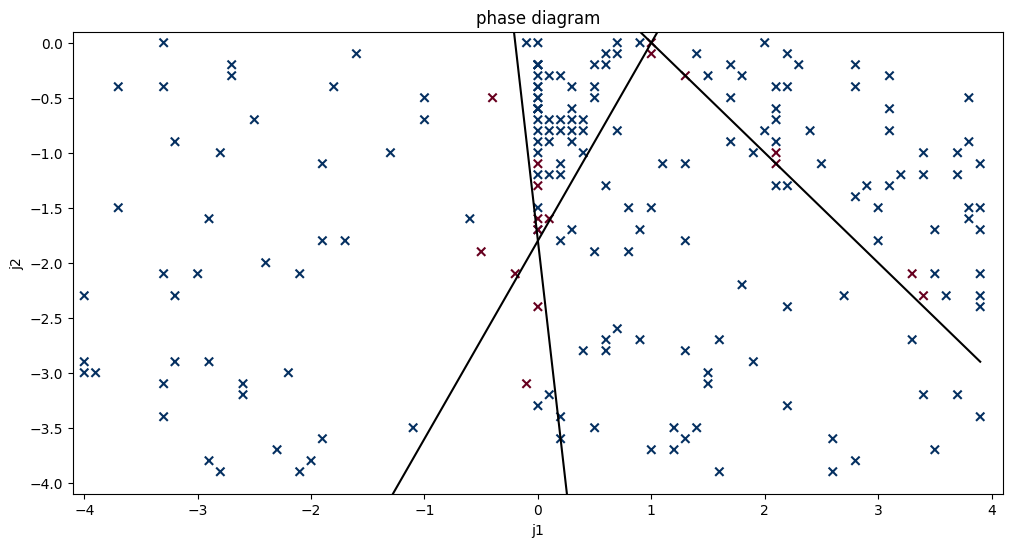

In [260]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# line = 
x_ticks = np.arange(-4, 4, 0.1)  # Every third tick position
y_ticks = np.arange(0, -4, -0.1)  # Every third tick position

# plt.plot(x_ticks, x_ticks* lines[0][1] +lines[0][1], color='black')
plt.plot(x_ticks, x_ticks* lines[0][0] +lines[0][1], color='black')
plt.plot(x_ticks, x_ticks* lines[2][0] +lines[2][1], color='black')
plt.plot(x_ticks, x_ticks* lines[3][0] +lines[3][1], color='black')
plt.scatter(x=df_tested['J1']/10, y=df_tested['J2']/10, c=df_tested['predicted_phase']==df_tested['phase'], cmap='RdBu', marker='x')

plt.xlim(-4.1, 4.1)
plt.ylim(-4.1, 0.1)

plt.title("phase diagram")
plt.xlabel("j1")
plt.ylabel("j2")
plt.show()

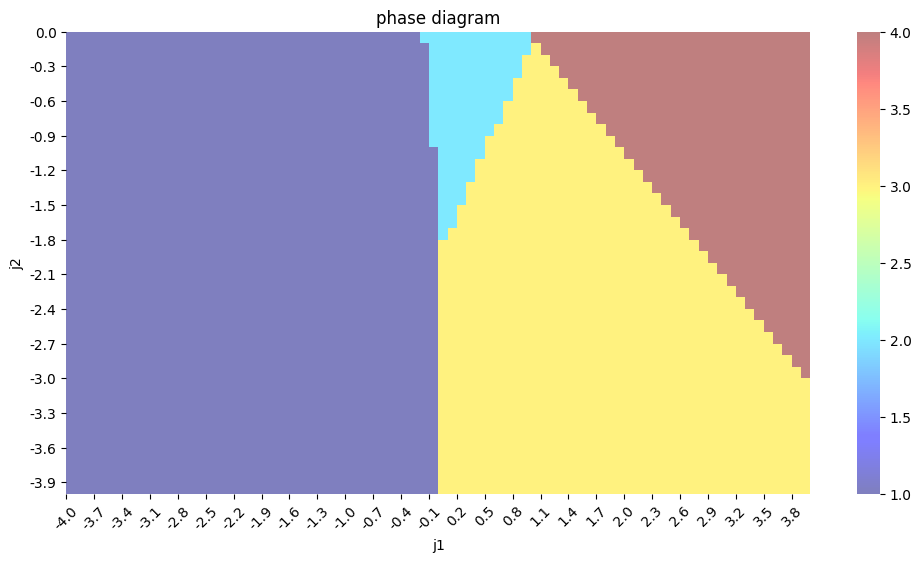

In [261]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate the heatmap without labels first
ax = sns.heatmap(mesh_phase, cmap="jet", xticklabels=False, yticklabels=False, alpha=0.5)

# Plot datapoints
# ax.scatter(x=df_tested['J1']*10, y=df_tested['J2']*10)

# Define the tick positions and labels
x_ticks = np.arange(0, len(np.arange(-4, 4, 0.1)), 3)  # Every third tick position
y_ticks = np.arange(0, len(np.arange(0, -4, -0.1)), 3)  # Every third tick position

x_labels = np.round(np.arange(-4, 4, 0.1), 2)[::3]  # Every third tick label
y_labels = np.round(np.arange(0, -4, -0.1), 2)[::3]  # Every third tick label

# Set the tick positions and labels on the plot
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels,rotation=45)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)

# Customize the plot
plt.title("phase diagram")
plt.xlabel("j1")
plt.ylabel("j2")
plt.show()